In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN

In [3]:
# Load the synthetic data
df = pd.read_csv('synthetic_absorbance_data.csv', index_col=0)

# Define the wavelength range
wavelengths = np.linspace(250, 500, 500)

# Calculate the variance of absorbance at each wavelength
absorbance_variance = df.var(axis=0)


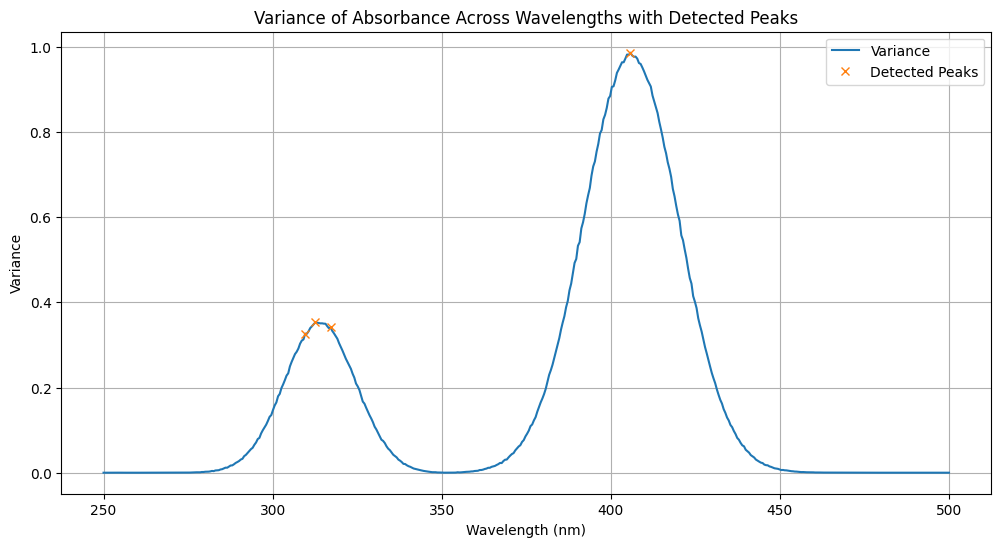

In [4]:
# Find peaks in the variance data
peaks, _ = find_peaks(absorbance_variance, height=0.1, distance=5)

# Extract the wavelengths corresponding to the peaks
peak_wavelengths = wavelengths[peaks]
peak_variances = absorbance_variance.iloc[peaks]

# Plot variance with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(wavelengths, absorbance_variance, label='Variance')
plt.plot(peak_wavelengths, peak_variances, "x", label='Detected Peaks')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Variance')
plt.title('Variance of Absorbance Across Wavelengths with Detected Peaks')
plt.legend()
plt.grid(True)
plt.show()


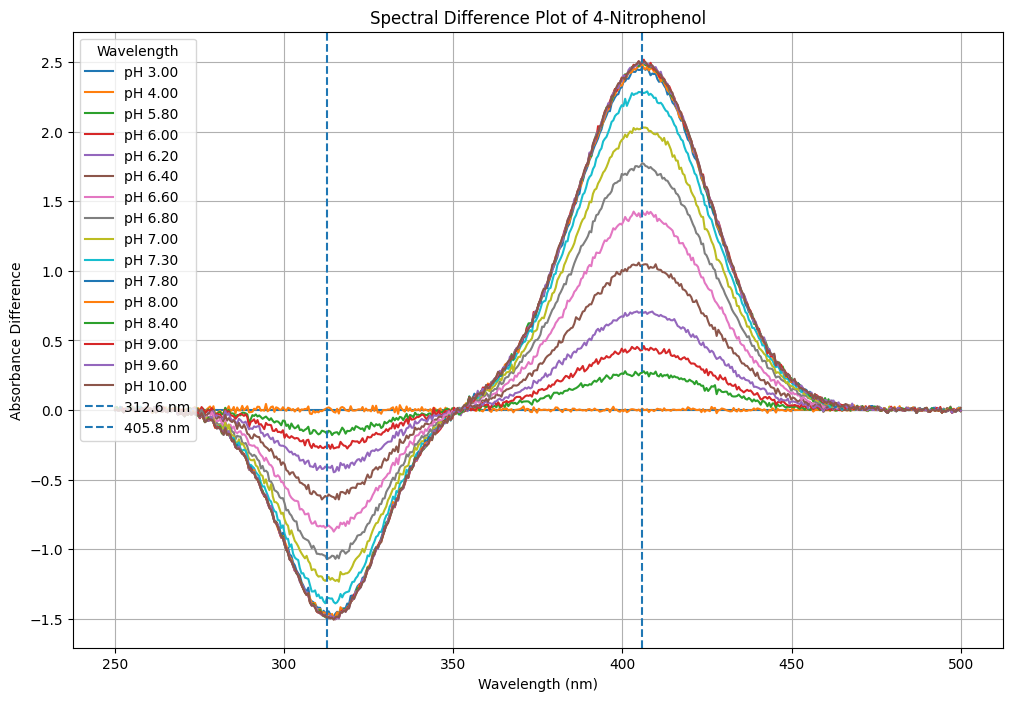

In [5]:
# Use DBSCAN to cluster the peaks
peak_wavelengths_array = peak_wavelengths.reshape(-1, 1)
clustering = DBSCAN(eps=10, min_samples=1).fit(peak_wavelengths_array)
labels = clustering.labels_

# Select the most significant peak within each cluster
final_wavelengths = []
for label in np.unique(labels):
    cluster_indices = np.where(labels == label)[0]
    cluster_peaks = peak_wavelengths[cluster_indices]
    cluster_variances = peak_variances.iloc[cluster_indices]
    most_significant_peak = cluster_peaks[np.argmax(cluster_variances)]
    final_wavelengths.append(most_significant_peak)

# Plot the spectral difference with significant wavelengths
plt.figure(figsize=(12, 8))
for i in range(len(df)):
    plt.plot(wavelengths, df.iloc[i] - df.iloc[0], label=f'pH {df.index[i]:.2f}')

# Highlight significant wavelengths
for wavelength in final_wavelengths:
    plt.axvline(x=wavelength, linestyle='--', label=f'{wavelength:.1f} nm')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Absorbance Difference')
plt.title('Spectral Difference Plot of 4-Nitrophenol')
plt.legend(title='Wavelength', bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.grid(True)
plt.show()


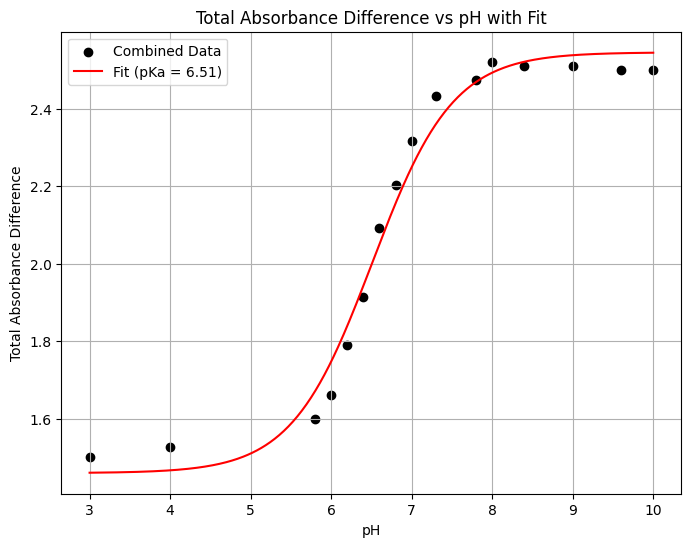

Determined pKa value: 6.51


In [6]:
from scipy.optimize import curve_fit

# Calculate the total absorbance difference at significant wavelengths
total_abs_diff = np.zeros(len(df))
for wavelength in final_wavelengths:
    closest_wavelength = df.columns.get_loc(str(wavelength))
    total_abs_diff += df.iloc[:, closest_wavelength].abs()

# Define the sigmoidal function for fitting
def sigmoid(pH, pKa, a, b):
    return a / (1 + np.exp(-(pH - pKa) * 2)) + b

# Fit the combined data
p0 = [6.5, max(total_abs_diff) - min(total_abs_diff), min(total_abs_diff)]  # Improved initial guess
popt, _ = curve_fit(sigmoid, df.index, total_abs_diff, p0, maxfev=10000)

# Extract the pKa value
pKa_value = popt[0]

# Plot the fit
pH_range = np.linspace(3, 10, 500)
fit = sigmoid(pH_range, *popt)

plt.figure(figsize=(8, 6))
plt.scatter(df.index, total_abs_diff, color='black', label='Combined Data')
plt.plot(pH_range, fit, label=f'Fit (pKa = {pKa_value:.2f})', color='red')
plt.xlabel('pH')
plt.ylabel('Total Absorbance Difference')
plt.title('Total Absorbance Difference vs pH with Fit')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

print(f'Determined pKa value: {pKa_value:.2f}')
